In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree

from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    roc_auc_score
)
df_raw = pd.read_csv('retail_data_sample.csv')
# Crear variable objetivo: Compra_online
df_raw['ventas'] = (df_raw['total_sales'] > 1500 ).astype(int)
df_raw.head()
# Crear variable objetivo
df_raw['ventas'] = (df_raw['total_sales'] > 1500 ).astype(int)# Seleccionar variables sin limpieza
df_before = df_raw[["unit_price", "quantity"]].dropna()
Xb = df_before.copy()
yb = df_raw.loc[df_before.index, "ventas"]


# División entrenamiento / prueba
Xb_train, Xb_test, yb_train, yb_test = train_test_split(Xb, yb, test_size=0.3, random_state=42)

# Modelo sin limpieza
model_before = LogisticRegression(max_iter=200)
model_before.fit(Xb_train, yb_train)

# Predicción y exactitud
yb_pred = model_before.predict(Xb_test)
acc_before = accuracy_score(yb_test, yb_pred)

print("✅ Exactitud antes de la limpieza:", round(acc_before, 4))
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler

# Copia del dataset original
df_clean = df_raw.copy()

# Imputación de valores numéricos
imputer_unit_price = SimpleImputer(strategy='median')
df_clean['unit_price'] = imputer_unit_price.fit_transform(df_clean[['unit_price']])

imputer_quantity = SimpleImputer(strategy='mean')
df_clean['quantity'] = imputer_quantity.fit_transform(df_clean[['quantity']])


cols_to_drop = [
    'customer_id', 'transaction_id', 'transaction_date', 'last_purchase_date',
    'product_id', 'product_name', 'product_brand', 'product_manufacture_date', 'product_expiry_date',
    'promotion_id', 'promotion_start_date', 'promotion_end_date',
    'customer_zip_code', 'store_zip_code', 'customer_city', 'store_city', 'total_items_purchased',
    'customer_state', 'store_state', 'preferred_store' ,'max_single_purchase_value', 'min_single_purchase_value',
    'total_returned_items' ,'avg_spent_per_category','total_returned_value', "product_color",'store_location', 'transaction_hour','day_of_week', 'week_of_year', 'month_of_year', 'product_material',"churned"
    
]

df_clean = df_clean.drop(columns=[col for col in cols_to_drop if col in df_clean.columns])
# Variables numéricas y categóricas razonables para el modelo
categorical = ['gender', 'income_bracket', 'loyalty_program', 'marital_status', 'education_level',
               'occupation', 'season', 'weekend','payment_method', 'product_category','promotion_target_audience', 'promotion_channel','promotion_type' ,'promotion_effectiveness']

numerical = ['age', 'membership_years', 'number_of_children', 'avg_purchase_value', 
             'purchase_frequency', 'avg_discount_used', 'online_purchases', 
             'in_store_purchases', 'avg_items_per_transaction', 'avg_transaction_value',
             'product_rating', 'product_review_count', 'product_stock', 'product_return_rate',
             'product_size', 'product_weight', 'distance_to_store', 'holiday_season',
             'customer_support_calls', 'website_visits', 'days_since_last_purchase','total_transactions', "total_sales",'total_discounts_received','quantity' ,'unit_price','discount_applied' 
             , 'email_subscriptions'
            ,'app_usage','social_media_engagement'
            ]
# Filtrar el dataset para incluir solo estas variables (si existen)
vars_to_use = categorical + numerical + ['ventas']  # incluir la variable objetivo
df_model = df_clean[[col for col in vars_to_use if col in df_clean.columns]].copy()

from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer

# Imputar valores faltantes
for col in df_model.select_dtypes(include='number').columns:
    if df_model[col].isnull().sum() > 0:
        df_model[col].fillna(df_model[col].median(), inplace=True)
# Codificar variables categóricas
categorical_cols = df_model.select_dtypes(include=['object', 'category']).columns.tolist()

# Aplicar codificación one-hot
df_model = pd.get_dummies(df_model, columns=categorical_cols, drop_first=True)

# Convertir columnas booleanas a enteros
df_model = df_model.astype({col: int for col in df_model.columns if df_model[col].dtype == 'bool'})

# Escalar numéricas
scaler = MinMaxScaler()
numerical_scaled = [col for col in numerical if col in df_model.columns]
df_model[numerical_scaled] = scaler.fit_transform(df_model[numerical_scaled])
# Definir variables predictoras y objetivo usando el dataset limpio
Xc = df_model.drop(columns=['ventas', "total_sales"])
yc = df_model['ventas']

# División entrenamiento / prueba
Xc_train, Xc_test, yc_train, yc_test = train_test_split(Xc, yc, test_size=0.3, random_state=42)

# Modelo después de la limpieza
model_after = LogisticRegression(max_iter=1000)
model_after.fit(Xc_train, yc_train)

yc_pred = model_after.predict(Xc_test)
acc_after = accuracy_score(yc_test, yc_pred)
print("✅ Exactitud después de limpieza:", round(acc_after, 2))

✅ Exactitud antes de la limpieza: 0.8607
✅ Exactitud después de limpieza: 0.86


In [11]:
print("Distribución real de clases:")
print(yc_train.value_counts(normalize=True).rename({0: "Ventas bajas", 1: "Ventas altas"}))

Distribución real de clases:
ventas
Ventas altas    0.865
Ventas bajas    0.135
Name: proportion, dtype: float64


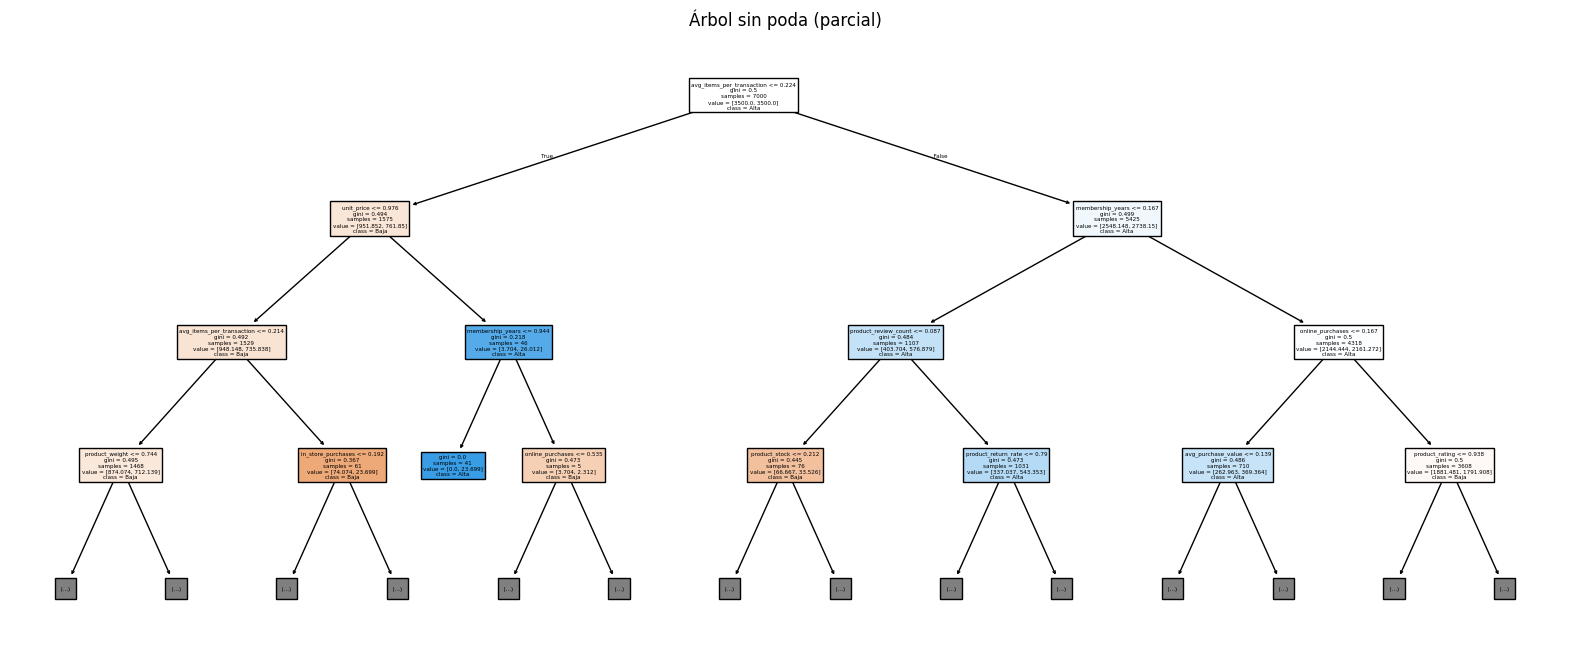

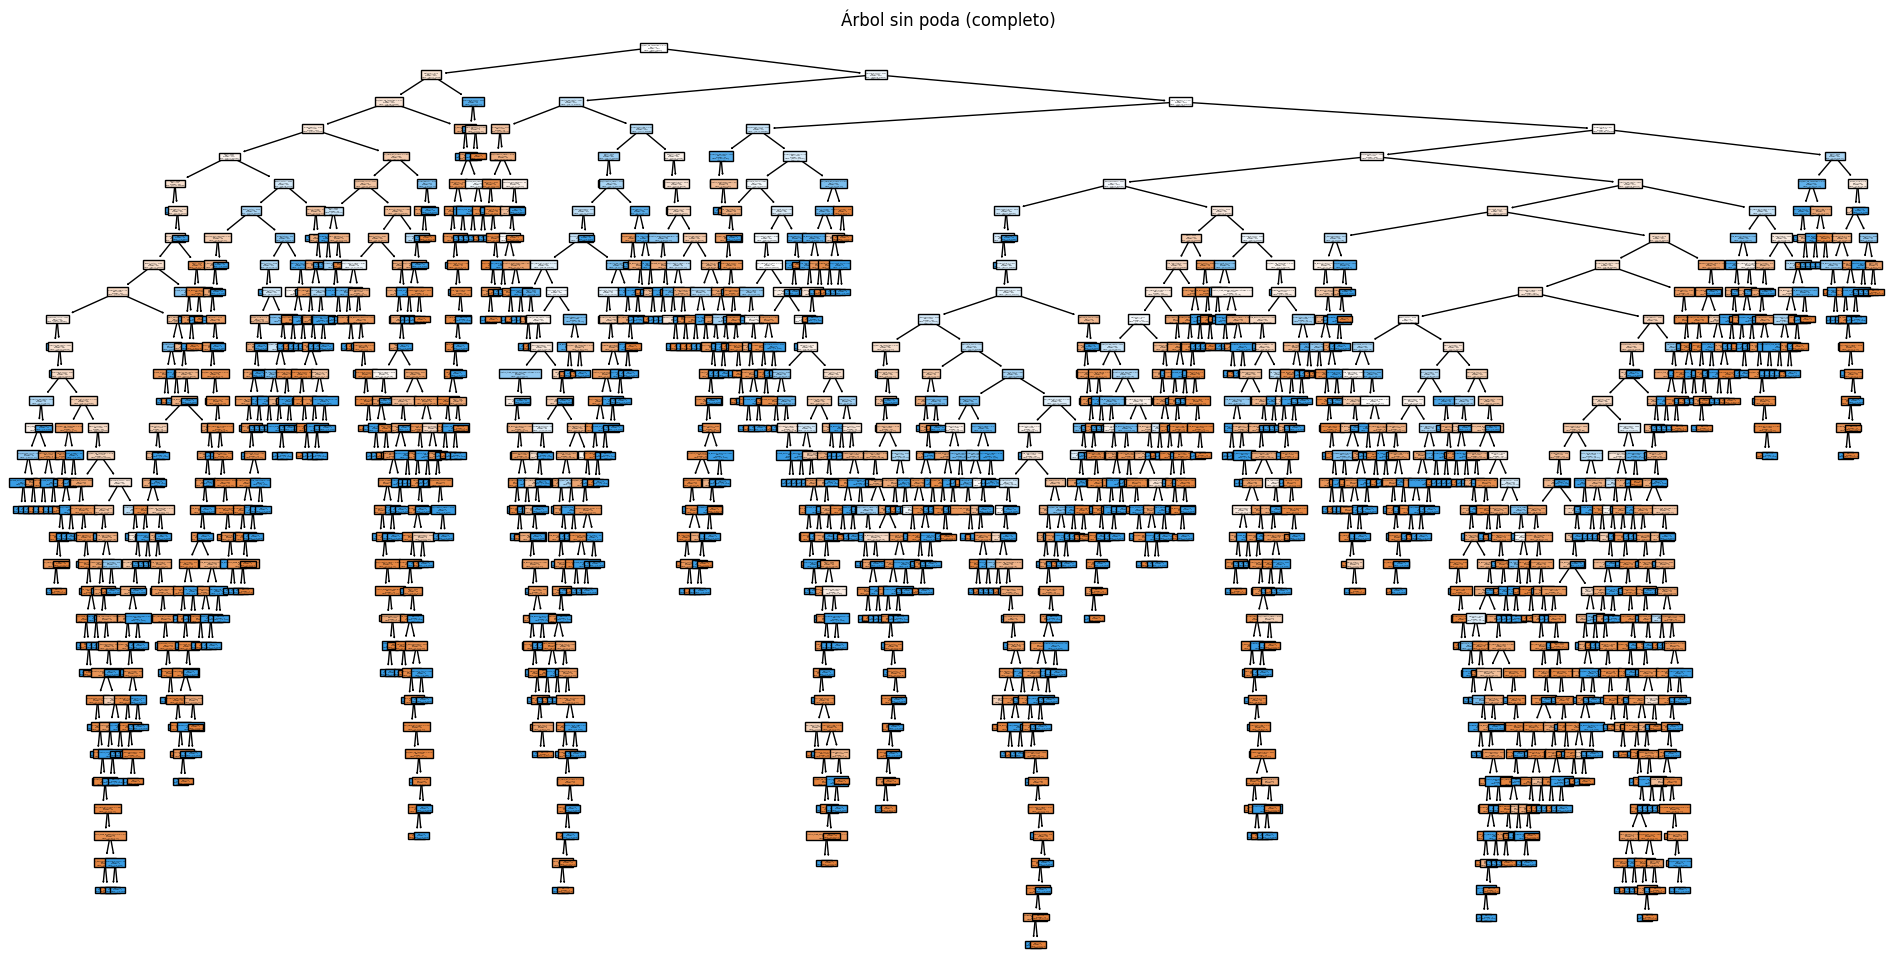

📊 Reporte de clasificación - Árbol sin poda
              precision    recall  f1-score   support

           0       0.15      0.14      0.15       418
           1       0.86      0.88      0.87      2582

    accuracy                           0.78      3000
   macro avg       0.51      0.51      0.51      3000
weighted avg       0.76      0.78      0.77      3000



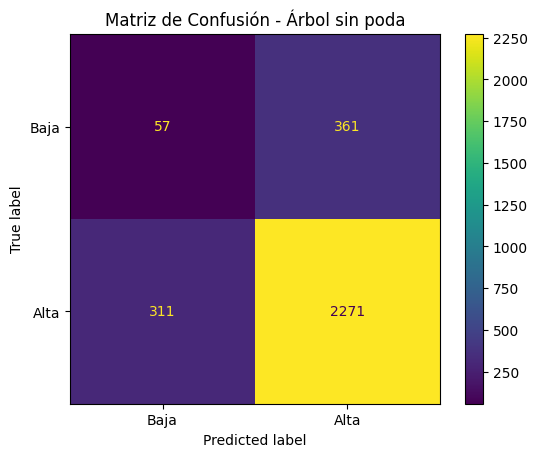

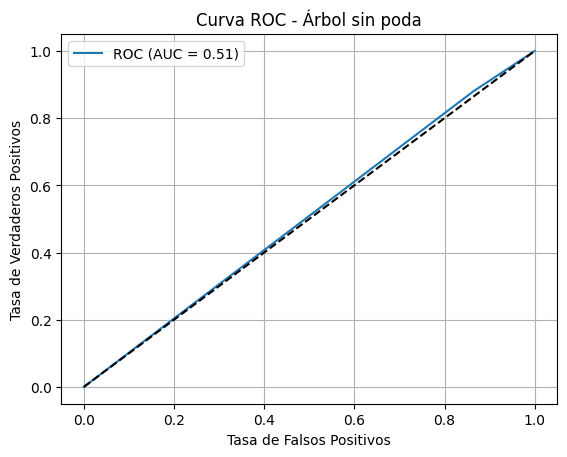

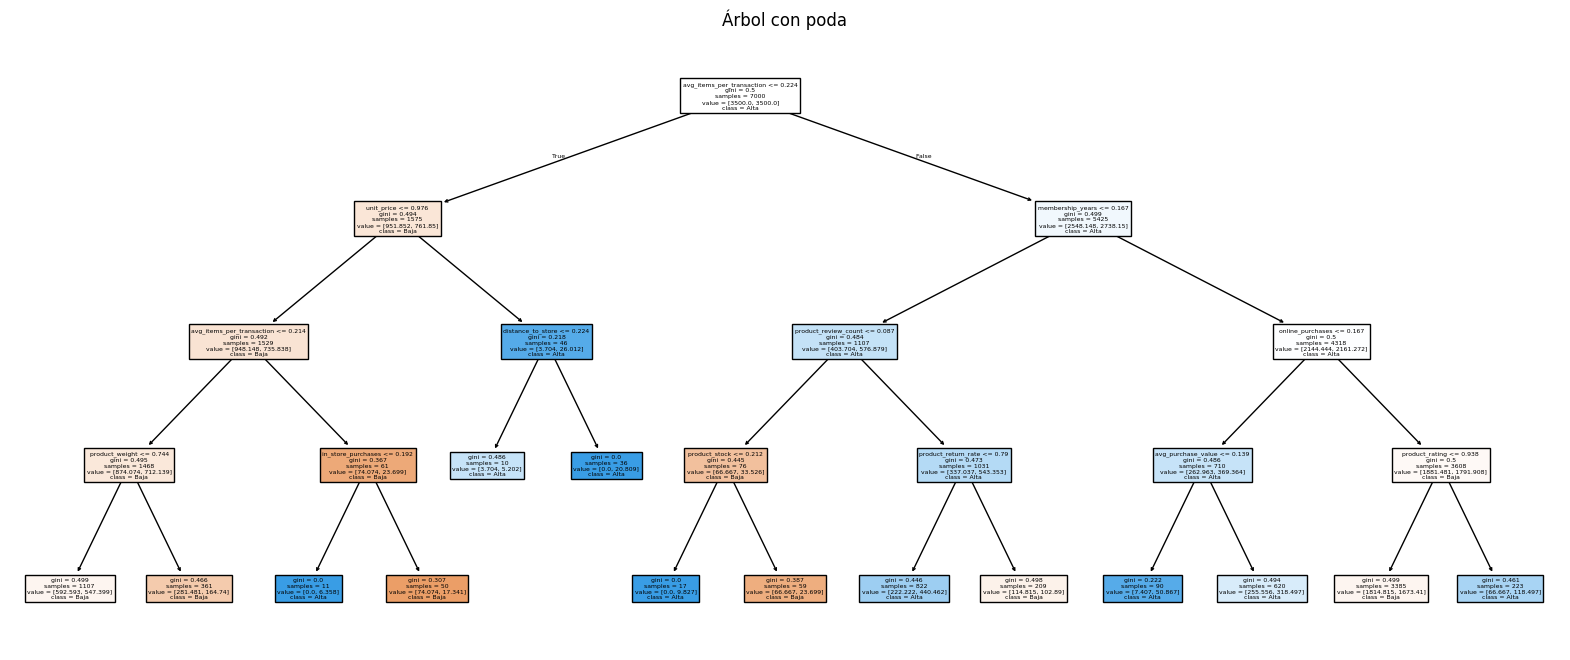

📊 Reporte de clasificación - Árbol podado
              precision    recall  f1-score   support

           0       0.14      0.74      0.24       418
           1       0.86      0.26      0.40      2582

    accuracy                           0.33      3000
   macro avg       0.50      0.50      0.32      3000
weighted avg       0.76      0.33      0.38      3000



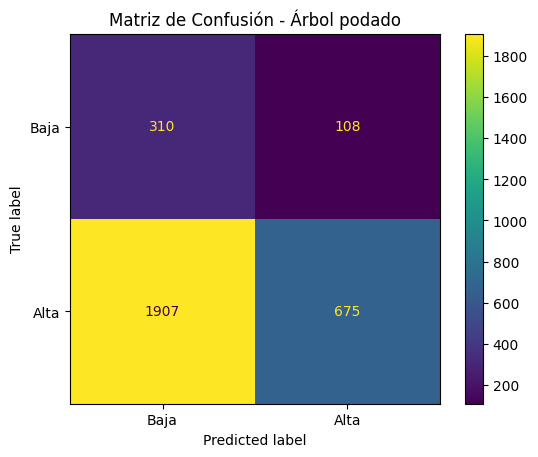

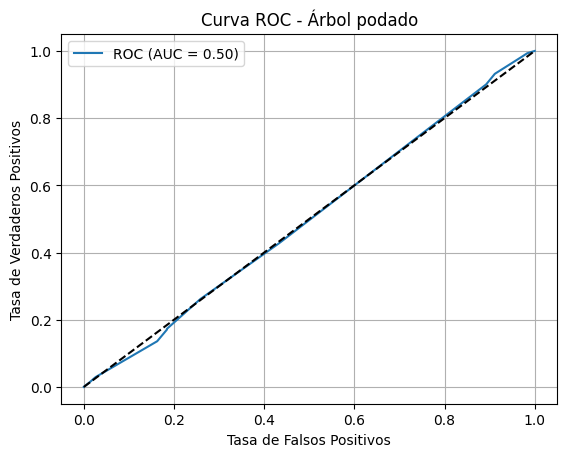

In [10]:
# Comparación Árbol de Decisión: Sin Poda vs Con Poda
# Dataset: Predicción de ventas significativas

import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import (
    classification_report,
    ConfusionMatrixDisplay,
    roc_curve,
    auc
)

# 1. Árbol sin poda (completo)
tree_full = DecisionTreeClassifier(class_weight='balanced', random_state=42 )
tree_full.fit(Xc_train, yc_train)

# Visualización parcial
plt.figure(figsize=(20, 8))
plot_tree(tree_full, feature_names=Xc_train.columns, class_names=["Baja", "Alta"], filled=True, max_depth=3)
plt.title("Árbol sin poda (parcial)")
plt.show()

# Visualización completa
plt.figure(figsize=(24, 12))
plot_tree(tree_full, feature_names=Xc_train.columns, class_names=["Baja", "Alta"], filled=True)
plt.title("Árbol sin poda (completo)")
plt.show()

# Evaluación sin poda
y_pred_full = tree_full.predict(Xc_test)
print("📊 Reporte de clasificación - Árbol sin poda")
print(classification_report(yc_test, y_pred_full))

ConfusionMatrixDisplay.from_estimator(tree_full, Xc_test, yc_test, display_labels=["Baja", "Alta"])
plt.title("Matriz de Confusión - Árbol sin poda")
plt.show()

y_scores = tree_full.predict_proba(Xc_test)[:, 1]
fpr, tpr, _ = roc_curve(yc_test, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("Tasa de Falsos Positivos")
plt.ylabel("Tasa de Verdaderos Positivos")
plt.title("Curva ROC - Árbol sin poda")
plt.legend()
plt.grid(True)
plt.show()

# 2. Árbol con poda (max_depth y min_samples_leaf)
tree_pruned = DecisionTreeClassifier(max_depth=4, min_samples_leaf=10,class_weight='balanced', random_state=42)
tree_pruned.fit(Xc_train, yc_train)

plt.figure(figsize=(20, 8))
plot_tree(tree_pruned, feature_names=Xc_train.columns, class_names=["Baja", "Alta"], filled=True)
plt.title("Árbol con poda")
plt.show()

# Evaluación árbol podado
y_pred_pruned = tree_pruned.predict(Xc_test)
print("📊 Reporte de clasificación - Árbol podado")
print(classification_report(yc_test, y_pred_pruned))

ConfusionMatrixDisplay.from_estimator(tree_pruned, Xc_test, yc_test, display_labels=["Baja", "Alta"])
plt.title("Matriz de Confusión - Árbol podado")
plt.show()

y_scores_pruned = tree_pruned.predict_proba(Xc_test)[:, 1]
fpr_pruned, tpr_pruned, _ = roc_curve(yc_test, y_scores_pruned)
roc_auc_pruned = auc(fpr_pruned, tpr_pruned)

plt.figure()
plt.plot(fpr_pruned, tpr_pruned, label=f"ROC (AUC = {roc_auc_pruned:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("Tasa de Falsos Positivos")
plt.ylabel("Tasa de Verdaderos Positivos")
plt.title("Curva ROC - Árbol podado")
plt.legend()
plt.grid(True)
plt.show()





Tenemos que el Accurancy del árbol sin poda está al 78% y el podado 33%, siendo que el árbol sin podar logra alta precisión pero es por lo que predice la clase mayoritaria (ventas altas), mientras que cuando lo podamos ya s elogra una exactitud global.

En la curva AUC sin poda: 0.51, AUC podado: 0.50

👉 Ambos árboles están muy cerca del azar. El modelo no tiene capacidad real de discriminar entre clientes que sí y no realizarán ventas altas

Si se quiere identificar clientes de ventas bajas el ideal es el árbol podado